In [1]:
!pip install pytorch_lightning
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.0 MB/s eta 0:00:00


In [2]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR = "/content/drive/MyDrive/MADE/RecSys"

In [5]:
pd.read_json(DATA_DIR + "/RecSystracks_with_recs.json", lines=True)

,artist,title,track,recommendations
0,Jack Johnson,The Cove,0,"[2013, 3687, 6084, 1209, 7018, 2441, 10168, 24..."
1,Billy Preston,Nothing from Nothing,1,"[568, 20447, 27015, 671, 268, 6805, 1829, 9838..."
2,Paco De Lucia,Entre Dos Aguas,2,"[627, 14545, 515, 16577, 40627, 22280, 2042, 2..."
3,Josh Rouse,Under Cold Blue Stars,3,"[14841, 410, 5198, 413, 419, 420, 7238, 5229, ..."
4,The Dead 60s,Riot Radio (Soundtrack Version),4,"[5089, 387, 822, 7585, 821, 4179, 830, 2008, 7..."
...,...,...,...,...
49995,Alain Bashung,Osez Joséphine,49995,"[10325, 126, 4204, 10822, 5405, 6629, 3059, 44..."
49996,Habib Koité,Kanawa,49996,"[816, 830, 382, 16523, 18180, 7379, 360, 10195..."
49997,De Saloon,Morder,49997,"[152, 5158, 9360, 8096, 6591, 442, 22354, 1305..."
49998,She Wants Revenge,Red Flags And Long Nights,49998,"[171, 10620, 12837, 16171, 789, 3685, 3687, 36..."


In [6]:
data = pd.read_json(DATA_DIR + "/data_seminar_04.json", lines=True)
# data = pd.read_json(DATA_DIR + "/data.json", lines=True)

In [7]:
data#.head(5)

,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2022-06-13 11:39:37.645,4013,18934,0.02,0.000206,NaN,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
1,next,2022-06-13 11:39:37.683,9693,29738,1.00,0.000902,3079.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
2,next,2022-06-13 11:39:37.692,9693,3079,0.06,0.000923,20078.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
3,next,2022-06-13 11:39:37.700,9693,20078,1.00,0.000858,12044.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
4,next,2022-06-13 11:39:37.708,9693,12044,0.00,0.000927,37424.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
...,...,...,...,...,...,...,...,...
815250,next,2022-06-13 11:39:37.604,4013,11115,1.00,0.000778,4360.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
815251,next,2022-06-13 11:39:37.612,4013,4360,0.00,0.001012,2189.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
815252,next,2022-06-13 11:39:37.621,4013,2189,0.02,0.000762,1924.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
815253,next,2022-06-13 11:39:37.629,4013,1924,0.01,0.000926,42099.0,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"


In [8]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [9]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

In [10]:
pairs.head(5)

,user,start,track,time
0,0,2999,5089,0.0
1,0,2999,5992,0.0
2,0,2999,7960,0.0
3,0,2999,1725,0.0
4,0,2999,2606,0.0


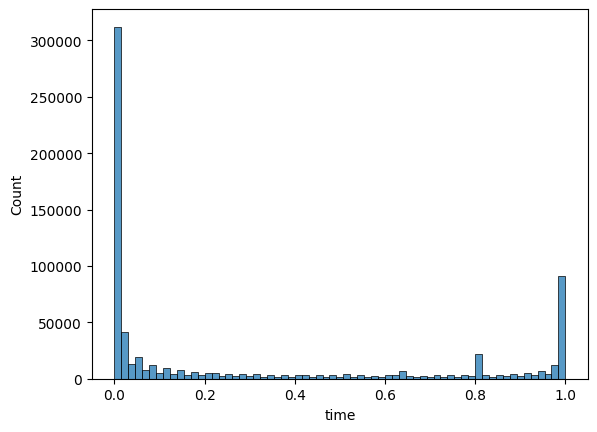

In [11]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [ ]:
'''
добавить второй датафрейм в класс датасет, где будут либо эмбеддинги юзеров и айтемов, либо матрица интеракций.
эту матрицу факторизовать и элементы поэлементно перемножить, либо сделать то же самое но с эмбеддингами
вопрос только как должны выглядеть эмбеддинги, посмотреть во 2 семинаре как выглядят эмбеддинги юзеров, типа
это эмбеддинги user_id и item_id или что
1 попробовать архитектуру где млп будет таким же как и раньше (скалярным произведение), а мф будет прогоняться через сигмоиду и суммироваться с результатом млп
2 попробовать подать обычный датафрейм без groupby и pairs 
3 и попробовать матрицу интеракций 
 
'''

'\nдобавить второй датафрейм в класс датасет, где будут либо эмбеддинги юзеров и айтемов, либо матрица интеракций.\nэту матрицу факторизовать и элементы поэлементно перемножить, либо сделать то же самое но с эмбеддингами\nвопрос только как должны выглядеть эмбеддинги, посмотреть во 2 семинаре как выглядят эмбеддинги юзеров, типа\nэто эмбеддинги user_id и item_id или что\n1 попробовать архитектуру где млп будет таким же как и раньше (скалярным произведение), а мф будет прогоняться через сигмоиду и суммироваться с результатом млп\n2 попробовать подать обычный датафрейм без groupby и pairs \n3 и попробовать матрицу интеракций \n \n'

In [12]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [ ]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        return torch.sum(context * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [13]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.linear1 = nn.Linear(self.embedding_dim*2, self.embedding_dim*3)
        self.linear2 = nn.Linear(self.embedding_dim*3, 64)
        self.relu = nn.ReLU()
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.user = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

        self.affine_output = torch.nn.Linear(in_features=self.embedding_dim, out_features=1)
        self.logistic = torch.nn.Sigmoid()

        # self.fc_layers = torch.nn.ModuleList()
        # for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
        #     self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        # self.mlp_output = torch.nn.Linear(in_features=layers[-1], out_features=1)

    def forward(self, x):
        #mlp
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        user = self.user(x[:,2]) # user
        # res = torch.cat((context, track), 1)
        # res = self.relu(self.linear1(res))
        # res = self.linear2(res)
        res = torch.sum(context * track, dim=1)
        # print('res', res.shape)
        
        # mf
        mf_res = torch.mul(user, track)
        mf_res = self.affine_output(mf_res).view(-1)
        # print('mf res', mf_res.shape)
        
        #concat of mf and mlp
        # res = torch.cat((mf_res, res), 1)
        res = mf_res + res
        # print('res after sum', res.shape)
        # res = self.affine_output(res)
        res = self.logistic(res)
        
        return res.view(-1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        # loss = F.mse_loss(predictions, y.float(), reduction='mean')
        loss = torch.sqrt(F.mse_loss(predictions, y.float(), reduction='mean'))
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [14]:
class ContextualRankerData(pl.LightningDataModule):
  def __init__(self, train_data, val_data, test_data, features):
      super().__init__()
      self.train_data = train_data
      self.val_data = val_data
      self.test_data = test_data
      self.features = features

  def prepare_data(self):
      self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

  def setup(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(self.train_data[self.features].values), 
            torch.from_numpy(self.train_data["time"].values)
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
            )
        
      if stage == "test" or stage is None:  
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )
  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [15]:
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track", 'user'])
data_module.setup(stage = "fit")
em = nn.Embedding(num_embeddings=50000, embedding_dim=3)
for x,y in data_module.train_dataloader():
  print(em(x[:2,1]))
  print(torch.cat((em(x[:2,1]), em(x[:2,0])), 1))
  break

tensor([[ 0.3775,  1.9040, -0.8305],
        [ 0.5865, -0.2531, -0.2207]], grad_fn=<EmbeddingBackward0>)
tensor([[ 0.3775,  1.9040, -0.8305, -0.1187, -2.4086,  1.6263],
        [ 0.5865, -0.2531, -0.2207,  0.6142,  0.1571,  0.7682]],
       grad_fn=<CatBackward0>)


In [15]:
embedding_dim = 16
net = ContextualRanker(embedding_dim=embedding_dim)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track", 'user'])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [16]:
trainer.fit(
    net, 
    data_module
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type      | Params
--------------------------------------------
0 | linear1       | Linear    | 1.6 K 
1 | linear2       | Linear    | 3.1 K 
2 | relu          | ReLU      | 0     
3 | context       | Embedding | 800 K 
4 | track         | Embedding | 800 K 
5 | user          | Embedding | 800 K 
6 | affine_output | Linear    | 17    
7 | logistic      | Sigmoid   | 0     
--------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.619     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00036: reducing learning rate of group 0 to 1.0000e-04.


In [17]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=16)

In [18]:
trainer.test(best, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │    0.15447917580604553    │
│         rdm_loss          │    0.2776205241680145     │
│         test_loss         │    0.10988645255565643    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10988645255565643,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.2776205241680145}]

## Compute top recommendations

In [19]:
track_meta = pd.read_json(DATA_DIR + "/tracks.json", lines=True)

In [20]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [21]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [22]:
k = 50
with open(DATA_DIR + "/RecSystracks_with_recs.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [02:35, 322.07it/s]


In [ ]:
track = 3916
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

In [ ]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]